In [1]:
import numpy as np
from functools import partial
import ipywidgets as widgets
from IPython.display import display

In [2]:

from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions
from pydrake.all import PiecewisePolynomial, InverseKinematics, Sphere, Rgba, RigidTransform, RotationMatrix, IrisInConfigurationSpace
import time
import pydrake


In [3]:
from environments import get_environment_builder

plant_builder = get_environment_builder('7DOFIIWA')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
Ratfk = RationalForwardKinematics(plant)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

q = np.zeros(plant.num_positions())
ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)
def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)   

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)

def showres_s(s_vis):
    showres(Ratfk.ComputeQValue(s_vis, np.zeros(7)))

def showres(qvis):
    plant.SetPositions(plant_context, qvis)
    col = col_func_handle(qvis)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    diagram.ForcedPublish(diagram_context)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q1', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q2', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q3', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q4', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='q5', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='q6', max=3.05433, min=-3.05433)

In [5]:
q

array([0., 0., 0., 0., 0., 0., 0.])

In [6]:
# start = np.array([-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
#         0.74567])
# end = np.array([ 1.23294, -0.1944 ,  0.     ,  1.6056 ,  1.43294,  1.1056 ,
#         0.24567])

poi =np.array([
    #[-2.06706, -0.3944 ,  1.43294,  0.9056 ,  0.53294, -0.8944 ,
     #   0.74567],
        [ 1.83294, -0.0944 , -0.06706, -1.2944 ,  1.53294,  1.4056 ,
        0.34567],
        [ 1.23294, -0.1944 ,  0.     ,  1.6056 ,  1.43294,  1.1056 ,
        0.24567],
        [ 1.23294, -0.1944 ,  0.     ,  1.1056 ,  1.43294,  1.1056 ,
       -0.15433],
       [ 1.23294, -0.4944 , -0.06706,  2.0056 ,  1.23294,  1.3056 ,
        0.94567],
        
        [ 1.83294,  0.3056 , -0.06706, -1.3944 ,  1.53294,  1.4056 ,
       -0.05433],
       [ 1.63294,  0.7056 ,  0.23294, -1.6944 ,  1.53294,  1.2056 ,
       -0.65433]])
showres(poi[0])

In [7]:
import os 
'experiment_7dof_iiwa__1_1500_0.300greedy20230908201834' in os.listdir('logs')

False

In [8]:
import pickle
path = 'logs_icra_paper/experiment_7dof_iiwa__1_1500_0.300greedy20230908201834'
with open(path+'/data/it_2.pkl', 'rb') as f:
    data = pickle.load(f)

regions = []
for ga,gb in zip(data['ra'], data['rb']):
    for a,b in zip(ga,gb):
        regions.append(HPolyhedron(a,b))
regions = regions[:43]

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
from visibility_utils import point_in_regions
for p in poi:
    print(point_in_regions(p, regions))

False
False
False
False
False
False


In [10]:
from region_generation import SNOPT_IRIS_obstacles
def estimate_coverage(r):
    return 0
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 6
snopt_iris_options.configuration_space_margin = 2e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 15
snopt_iris_options.relative_termination_threshold = 0.02

iris_handle = partial(SNOPT_IRIS_obstacles, 
                        logger = None, 
                        plant = plant, 
                        context = diagram_context,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)


showres(poi[4,:])

# 213  054
seq = [2,1,3,5,4,0,2] 
# r_poi,_ = iris_handle(poi, [], [])
#r_poi = [r1[0],r2[0]]
# with open('rpoi_3shelf.pkl', 'wb') as f:
#     ra = [r.A() for r in r_poi]
#     rb = [r.b() for r in r_poi]
#     pickle.dump([ra, rb], f)

In [11]:
import pickle
with open('tmp/rpoi_3shelf.pkl', 'rb') as f:
    rpoilist = pickle.load(f)

r_poi = []
for ra, rb in zip(rpoilist[0], rpoilist[1]):
    r_poi.append(HPolyhedron(ra,rb))
    ra = [r.A() for r in r_poi]
    rb = [r.b() for r in r_poi]
    #pickle.dump([ra, rb], f)

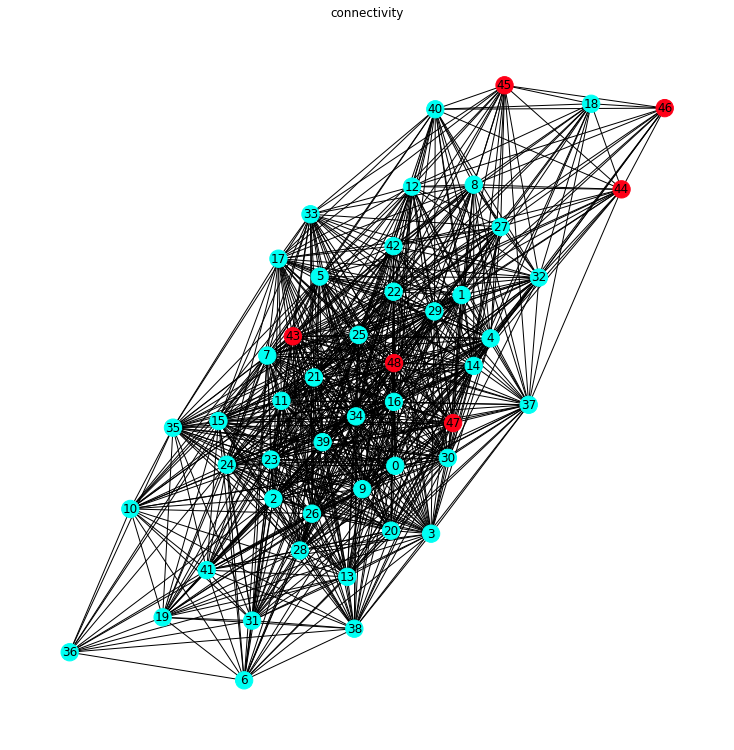

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors

regs = regions+r_poi
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)


for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regions, r_poi], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

def densify_waypoints(waypoints_q, densify = 200):
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [13]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions + r_poi, conversion_dummy)
# import pickle
# dsppname = "7dofnew_dspp_small.pkl"
# with open(dsppname, 'rb') as f:
#     dspp = pickle.load( f)
import pickle
dsppname = "tmp/7dofnew_dspp_small.pkl"
with open(dsppname, 'wb') as f:
    pickle.dump(dspp, f)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 49
[DijkstraSPP] Pre-Building adjacency matrix  10 / 49
[DijkstraSPP] Pre-Building adjacency matrix  20 / 49
[DijkstraSPP] Pre-Building adjacency matrix  30 / 49
[DijkstraSPP] Pre-Building adjacency matrix  40 / 49
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 800


In [14]:
colors = [(1,0,0,1),(1,1,0,1),
(0,1,0,1),
(0,1,1,1),
(0,0,1,1),
(1,0,1,1),
]

meshcat.Delete("/iris/points/traj/")
for idx,i in enumerate(seq[:-1]):
    wp, dist = dspp.solve(poi[i,:], poi[seq[idx+1],:], refine_path = True)
    wpd = densify_waypoints(wp)
    plot_endeff_traj(wpd, str(i), colors[i])




[DijkstraSPP] optimized distance/ start-distance = 1.24 / 4.70 = 0.26
[DijkstraSPP] optimized distance/ start-distance = 1.35 / 3.64 = 0.37
[DijkstraSPP] optimized distance/ start-distance = 5.62 / 8.48 = 0.66
[DijkstraSPP] optimized distance/ start-distance = 2.55 / 4.42 = 0.58
[DijkstraSPP] optimized distance/ start-distance = 0.94 / 4.02 = 0.23
[DijkstraSPP] optimized distance/ start-distance = 3.25 / 5.87 = 0.55


In [15]:
from pydrake.all import Mesh
a = Mesh('display_signs/7dofsign.gltf')
meshcat.SetObject('/instructionsign', a)
meshcat.SetTransform('/instructionsign',RigidTransform(
                            RotationMatrix.MakeZRotation(-np.pi/2)@RotationMatrix.MakeXRotation(-np.pi/2), 
                            np.array([0, 10 , 0])))

In [16]:
frame_time = 1/32.0
cur_time = 0
meshcat.SetProperty(f"/Grid", "visible", False)
meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)
meshcat.StartRecording()
animation = meshcat.get_mutable_recording()
for i in range(20):
    wp, dist = dspp.solve(poi[seq[(i)%len(seq)],:], poi[seq[(i+1)%len(seq)],:], refine_path = True)
    wpd = densify_waypoints(wp, 50)
    for qa in wpd:
        showres(qa)
        diagram_context.SetTime(cur_time)
        if col_func_handle(qa):
            print('col')
        cur_time+=frame_time
        time.sleep(frame_time)
meshcat.StopRecording()
animation.set_autoplay(True)
meshcat.PublishRecording()
with open("static_htmls/7DOF_IIWA.html", "w+") as f:
    f.write(meshcat.StaticHtml())

[DijkstraSPP] optimized distance/ start-distance = 1.24 / 4.70 = 0.26
[DijkstraSPP] optimized distance/ start-distance = 1.35 / 3.64 = 0.37
[DijkstraSPP] optimized distance/ start-distance = 5.62 / 8.48 = 0.66
[DijkstraSPP] optimized distance/ start-distance = 2.55 / 4.42 = 0.58
[DijkstraSPP] optimized distance/ start-distance = 0.94 / 4.02 = 0.23
[DijkstraSPP] optimized distance/ start-distance = 3.25 / 5.87 = 0.55
[DijkstraSPP] optimized distance/ start-distance = 0.00 / 0.00 = nan
[DijkstraSPP] optimized distance/ start-distance = 1.24 / 4.70 = 0.26
[DijkstraSPP] optimized distance/ start-distance = 1.35 / 3.64 = 0.37
[DijkstraSPP] optimized distance/ start-distance = 5.62 / 8.48 = 0.66
[DijkstraSPP] optimized distance/ start-distance = 2.55 / 4.42 = 0.58
[DijkstraSPP] optimized distance/ start-distance = 0.94 / 4.02 = 0.23
[DijkstraSPP] optimized distance/ start-distance = 3.25 / 5.87 = 0.55
[DijkstraSPP] optimized distance/ start-distance = 0.00 / 0.00 = nan
[DijkstraSPP] optimize

In [14]:
def plot_endeff_traj_s(dense,name = '', color = (1,0,0,1)):
    plot_endeff_traj(np.array([Ratfk.ComputeQValue(w,np.zeros(7)) for w in dense]), name, color)

def plot_endeff_traj(dense_waypoints, name = '', color= (1,0,0,1)):
    color = Rgba(color[0], color[1], color[2], color[3])
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(9)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.13

        meshcat.SetObject(f"/iris/points/traj/{name}/{i+start_idx}",
                               Sphere(0.01),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{name}/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))